## NYPD Data

### Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

### Data Import

In [3]:
pickle_path = ('../raw_data/clean-75-precinct.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

### Sample Selection

In [4]:
inf = df['period'] > datetime(2012, 1, 1, 0, 0, 0)
sup = df['period'] < datetime(2013, 1, 1, 0, 0, 0)
sample = df[ inf & sup ]

In [5]:
sample['longitude'].min(), sample['longitude'].max(), sample['latitude'].min(), sample['latitude'].max() 

(-73.904645897, -73.855902525, 40.607512254, 40.691192349)

In [6]:
del df

In [ ]:
sample.shape

### DataGenerator

In [ ]:
# import tensorflow as tf

# class CustomDataGenerator(tf.keras.utils.Sequence):
#   def __init__(self, df, batch_size=32, shuffle=True, lat_meters=100, lon_meters=100, *args, **kwargs):
#     self.df = df
#     self.batch_size = batch_size
#     self.indices = np.arange(len(self.df))
#     self.shuffle = shuffle
#     self.lat_meters = lat_meters
#     self.lon_meters = lon_meters
#     self.on_epoch_end()

#   def __len__(self):
#     """
#     Return the number of batches so the generator knows how many batches
#     it should generate for each epoch
#     """
#     return len(df) // self.batch_size

#   def __getitem__(self, i):
#     """
#     Return the i-th batch
#     """
#     batch_indices = self.indices[i * self.batch_size:(i + 1) * self.batch_size]
#     batch = self.df.iloc[batch_indices] 
#     return self.__get_data(batch)

#   def __get_data(self, batch):
#     X = from_coord_to_matrix(batch, lat_meters=self.lat_meters, lon_meters=self.lon_meters)
#     y = from_coord_to_matrix(batch, lat_meters=self.lat_meters, lon_meters=self.lon_meters) # à changer
#     return X, y

#   def on_epoch_end(self):
#     self.indices = np.arange(len(self.df))
#     if self.shuffle == True:
#         np.random.shuffle(self.indices)

In [ ]:
# BATCH_SIZE = 2

# datagen = CustomDataGenerator(df, batch_size=BATCH_SIZE)
# p, q = datagen.__getitem__(3)
# print(p.shape)
# print(q.shape)

### Lat - Long to Array

In [10]:
def from_meters_to_coords(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth's radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

In [7]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df = df.copy()
    #add 'time_index' column to df
    ind = {time: index for index, time in enumerate(np.sort(df['week'].unique()))}
    df['time_index'] = df['week'].map(ind)
    #initiate matrix
    #40.49611539518921, 40.91553277600008, -74.25559136315213,-73.70000906387347) : NYC boundaries
    #([40.56952999448672, 40.73912795313436],[-74.04189660705046, -73.83355923946421]) : brooklyn boundaries
    #[40.6218192717505, 40.6951504231971],[-73.90404639808888, -73.83559344190869]) :precinct 75 boundaries
    # Where do you start
    # grid_offset = np.array([-40.691192349, -73.904645897, 0])
    
    grid_offset = np.array([ -df['latitude'].max(), df['longitude'].min(), 0 ])
    
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([lat_spacing , lon_spacing,1]) # What's the space you consider (euclidian here)
    
    #get points coordinates
    coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                   in zip(df['latitude'],df['longitude'],df['time_index'])])
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0]
    Y = indexes[:,1]
    Z = indexes[:,2]
    #virgin matrix
    a = np.zeros((X.max()+1, Y.max()+1, Z.max()+1))
    a[X, Y, Z]=1
    return a, a.shape[0], a.shape[1]

In [8]:
sample['week'] = sample['period'].apply(lambda x: int(x.strftime('%V')))

In [11]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 15,10)

In [12]:
lat_size

622

In [13]:
lon_size

417

In [ ]:
img.shape

In [ ]:
plt.figure(figsize=(30, 30))

plt.imshow(img[:,:,10], cmap='gray');

### Plotting Array (with and w/o Gaussian filter)

In [ ]:
#plt.figure(figsize=(5, 5))
#plt.imshow(img[3], cmap='gray');

In [ ]:
# crime 
# sur 500m de chaque cote, 1 semaine a se deteriorer, 168h/2 (84t)
# 25 y 
# 50x


In [14]:
img3D_conv = gaussian_filter(img, sigma=(1,1,3))

In [25]:
img3D_conv.shape

(622, 417, 52)

In [ ]:
plt.figure(figsize=(10, 10))

plt.imshow(img3D_conv[:,:,4], cmap='gray');

### Splitting into X and y

In [32]:
def stacking(img3D, window, lat_step, lon_step, time_step):
    
    grid_offset = np.array([0,0,0]) # Where do you start
    
    #new steps from precise grid
    grid_spacing = np.array([lat_step , lon_step, time_step]) 
    #get points coordinates
    coords = np.argwhere(window)
    flat = window.flatten()
    values = flat[flat !=0]
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0] 
    Y = indexes[:,1] 
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((int(img3D.shape[0]/lat_step)+2, int(img3D.shape[1]/lon_step)+2,Z.max()+2))  
    
    for i in range(len(indexes)):
        if a[X[i], Y[i], Z[i]] == 0:
            a[X[i], Y[i], Z[i]] = values[i]
        else:
            a[X[i], Y[i], Z[i]] += values[i]
                        
    return a

In [27]:
def get_observation_target(img3D,
                           obs_timeframe,obs_lat,obs_lon, obs_time,
                           target_timeframe,  tar_lat,tar_lon, tar_time):
    '''
    output an observation of x_length consecutive images and the y_length next images as the target
    obs_step, obs_timeframe, target_step, target_timeframe : unit = hours
    '''
    #function from raw to hours
    print('creating obs')
    length = obs_timeframe + target_timeframe
    
    position = np.random.randint(0, img3D_conv.shape[2] - length)

    subsample = img3D[:, :, position : position + length]
    #print(subsample.shape)
    
    observations, targets = np.split(subsample,[obs_timeframe], axis=2) # divide the subsample in X and y
    
    #print(observations.shape)
    #print(observations.min(), observations.max())
    
    observation = stacking(img3D, observations, obs_lat, obs_lon, obs_time) #get stacked hours for all images
    print(observation.shape)
    #print (targets.shape)
    
    target = stacking(img3D, targets,  tar_lat, tar_lon, tar_time )
    print(target.shape)
    return observation, target

In [28]:
obs_lon = 20 # 20*10m together in lon
obs_lat = 10 # 10*15m
obs_time = 2 #  2 weeks stacked together
obs_tf = 12 # for 12weeks straight as X
tar_lon = 20 # 4*10m together in lon
tar_lat = 10 # 5*10m
tar_time = 2 # 2weeks stacked together
tar_tf = 4 # for 4weeks straight as y

In [ ]:
observation, target = get_observation_target(img3D_conv,
                                             obs_tf, obs_lat,obs_lon,  obs_time,
                                             tar_tf, tar_lat,tar_lon,  tar_time)

In [ ]:
observation.shape

In [ ]:
target.shape

### Subsampling to get multiple X and y

In [29]:
def get_X_y(img3D_conv, nb_observations, obs_tf,obs_lat,obs_lon, obs_time,
                tar_tf, tar_lat,tar_lon, tar_time):
    '''
    outputs n observations and their associated targets
    '''
    X = []
    y = []
    
    for n in range(nb_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv,
                                       obs_tf,obs_lat,obs_lon, obs_time,
                                       tar_tf,  tar_lat,tar_lon, tar_time)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)

    del X_subsample, y_subsample, n
    
    return X, y

In [30]:
obs_lon = 20 # 20*10m together in lon
obs_lat = 10 # 10*15m
obs_time = 2 #  2 weeks stacked together
obs_tf = 12 # for 12weeks straight as X
tar_lon = 20 # 4*10m together in lon
tar_lat = 10 # 5*10m
tar_time = 2 # 2weeks stacked together
tar_tf = 4 # for 4weeks straight as y

In [33]:
X, y = get_X_y(img3D_conv, 20,obs_tf, obs_lat,obs_lon, obs_time, tar_tf, tar_lat,tar_lon,  tar_time)

In [ ]:
# del img, img3D_conv, inf, sup, sample

In [34]:
X.shape

(20, 64, 22, 8)

In [35]:
y.shape

(20, 64, 22, 4)

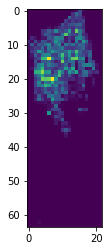

In [46]:

plt.imshow(X[0][:,:,0])

## Model

### Imports

In [36]:
# Train, test, split
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Train, test, split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # need to be applied before gaussian filter

In [ ]:
# del X,y

### Model

In [70]:

#CNN: Convolutionnal neural network used to tackle image processing problems => our located & timestamped crimes.
#CNN: specific neural network using: convolution, pooling, relu activation and fully connected layer.
#Our convolutional layer has a number of filters that perform convolutionnal operation.
#Every image is considered as a matrix pixel values.
#Considering the following image (give example) whose pixel values are only 0 and 1.
#We start from our image pixels, we pass a filter on it (give our filter shape + details) and we get a convolved feature/image (we call it image3D_conv/matrix from the same size as the filter shape.)
#Sliding the filter matrix over the matrix and computing the dot product to detect pattern.
#Relu layer: Once the feature maps are extracted, the next step is to move them to a ReLU layer.
    #The relu layer is the activation function that performs element wise operation, set all negative pixels to 0.introduce non linearity to the network and gives us as an output a rectified feature map.
    #Real image is scanned on multiple convolution layers for locating features.
    #We get a rectified feature map/img3d_conv

#Pooling layer: The rectified feature map/ our img3d_conv goes through a pooling layer. Pooling is a down-sampling operation that reduces the dimensionality of our feature map/our img3d convoluted.
#Pooling layer: A pooling layer uses different filters to identify different parts of the image like edges, corners etc.

def init_model(x_length, y_length, lat_size, lon_size):
    
    #1.using sequential model from Keras
    print('initializing model')
    model = models.Sequential()
    
    #2.This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    #relu activation function is used to activate this specific layer. 
    print('adding conv3D 1')
    model.add(layers.Conv3D(32, kernel_size = 10, activation = 'relu', padding='same',
                            input_shape = (lat_size, lon_size, x_length, 1)))
    
    #3.Pooling layer, pooling/reducing the number of parameters.(our feature map/our img3d convoluted) in a smaller matrix with only the max (with a certain filter of a squared shape (for example 2*2))
    print('Maxpooling')
    model.add(layers.MaxPooling3D(2))
    
    
    #4.Flattening: process of converting all the resultant 3D dimensional array from our max pooled feature map/img3Dconv&pooled into a single long continuous linear vector.
    # We get back a flattened matrix.     
    print('flattening')
    model.add(layers.Flatten())
    
    # 5.hidden layers
    print('adding dense layer 1')
    model.add(layers.Dense(lat_size, activation = 'relu'))
    
    #6.hidden layers
    print('adding dense layer 2')
    model.add(layers.Dense((lat_size * lon_size)/ 2, activation = 'relu'))
    
    #7.hidden layers
    print('adding dense layer 3')
    model.add(layers.Dense(lat_size * lon_size, activation = 'relu')) 
    
    #8. hidden layers
    #print('adding dense layer 4')
    #model.add(layers.Dense(lat_size * lon_size * y_length/2, activation = 'relu'))
    
    # Used in case of overfitting (drop 50% des neurones)
    #     print('adding dense layer 2')
    #     model.add(layers.Dropout(rate=0.5))

    
    #Fully connecting layer is our final output layer. Autant de neurone que de neurones dans reshape. Chaque neurone porte l'info finale.
    print('adding final dense layer')
    model.add(layers.Dense(y_length * lat_size * lon_size, activation = 'relu'))
    
    #reshape du fully conencting layer pour revenir a une same size
    print('Reshaping')
    model.add(layers.Reshape((lat_size, lon_size, y_length)))
    
    print('compiling')
    model.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = 'mae')
    print('Done !')
    
    return model

### Running Model (Instance, Early Stopping, Fit and Evaluate)

**Reminders**

**batch_size:** no. of data used to compute error between y_pred and y_true each time weights of neural network updated (use 16 or 32)

**epoch:** once all data has been used once to update the weights

In [60]:
X_train.shape

(16, 64, 22, 8)

In [61]:
y_train.shape

(16, 64, 22, 4)

In [71]:
model = init_model(X_train.shape[-1],y_train.shape[-1], X_train.shape[1], X_train.shape[2])

initializing model
adding conv3D 1
Maxpooling
flattening
adding dense layer 1
adding dense layer 2
adding dense layer 3
adding final dense layer
Reshaping
compiling
Done !


In [66]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 64, 22, 8, 32)     32032     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 32, 11, 4, 32)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 45056)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2883648   
_________________________________________________________________
dense_23 (Dense)             (None, 704)               45760     
_________________________________________________________________
dense_24 (Dense)             (None, 1408)              992640    
_________________________________________________________________
dense_25 (Dense)             (None, 5632)             

In [67]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                      batch_size = 32, 
                      epochs = 2,
                      validation_split = 0.3,
                      callbacks = es)

Epoch 1/2


ValueError: in user code:

    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: : expected min_ndim=5, found ndim=4. Full shape received: [None, 64, 22, 8]


In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['val_mae'])

In [ ]:
print(model.evaluate(X_test, y_test))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = flatten

In [ ]:
y_pred.reshape(y_length, lat_size, lon_size)

## From coord to map

In [ ]:
def from_matrix_to_coord(matrix, lat_meters, lon_meters):
        """
        gives back the coordinates from a 3D matrix for a given bucket height and width
        """
        results = []
        for observation in matrix:
            # Where do you start
            grid_offset = np.array([0, -40.91553277600008,  -74.25559136315213,])

            #from meters to lat/lon step
            lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters)

            # What's the space you consider (euclidian here)
            grid_spacing = np.array([1, lat_spacing, lon_spacing])

            indexes = np.argwhere(observation)
            #print(indexes.shape)
            # index : coords de mes crimes dans mon np array
            result = grid_offset + indexes * grid_spacing
            results.append(result)
        return np.array(results)

In [ ]:
y_pred_notsure = np.where((y_train>5*10**(-4)) & (y_train<5*10**(-3)), y_train, 0)
y_pred_middle = np.where((y_train>5*10**(-3)) & (y_train<1*10**(-2)), y_train, 0)
y_pred_sure = np.where(y_train>1*10**(-2), y_train, 0)

#y_pred_notsure = np.where((y_pred>5*10**(-3)) & (y_pred<1*10**(-2)), y_pred, 0)
#y_pred_middle = np.where((y_pred>1*10**(-2)) & (y_pred<1.8*10**(-2)), y_pred, 0)
#y_pred_sure = np.where(y_pred>1.8*10**(-2), y_pred, 0)

In [ ]:
coords_not_sure = from_matrix_to_coord(y_pred_notsure, 200, 200)
coords_middle = from_matrix_to_coord(y_pred_middle, 200, 200)
coords_sure = from_matrix_to_coord(y_pred_sure, 200, 200)

In [ ]:
coords_back_not_sure_df = pd.DataFrame(coords_not_sure[0], columns=['image', 'lat', 'lon'])
coords_back_not_sure_df['right_lat'] = -coords_back_not_sure_df['lat']

coords_middle_df = pd.DataFrame(coords_middle[0], columns=['image', 'lat', 'lon'])
coords_middle_df['right_lat'] = -coords_middle_df['lat']

coords_back_sure_df = pd.DataFrame(coords_sure[0], columns=['image', 'lat', 'lon'])
coords_back_sure_df['right_lat'] = -coords_back_sure_df['lat']

In [ ]:
last_image_not_sure = coords_back_not_sure_df[coords_back_not_sure_df['image']==2.0]
last_image_middle = coords_middle_df[coords_middle_df['image']==2.0]
last_image_sure = coords_back_sure_df[coords_back_sure_df['image']==2.0]

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(left=-74.25559136315213, right=-73.70000906387347)
ax.set_ylim(bottom = 40.49611539518921, top=40.91553277600008)
sns.scatterplot(x='lon', y='right_lat', data=last_image_not_sure, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_middle, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_sure, s=2, ax=ax)
plt.legend()

In [ ]:
#modèle clairement pourri car il indique des crimes sur staten island
#voir baseline modèle (on est en dessous)

## Trying another model

In [129]:
X_train.shape, y_train.shape

((16, 64, 22, 8), (16, 64, 22, 4))

In [125]:
model = models.Sequential()

model.add(layers.Conv3D(64, kernel_size = (4,4,4), activation = 'relu', padding='same',
                            input_shape = (64, 22, 8,1)))

model.add(layers.MaxPooling3D(2))

model.add(layers.Flatten())
model.add(layers.Dense(64*22*4, activation = 'relu'))

model.add(layers.Reshape((64,22,4)))

In [126]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 64, 22, 8, 64)     4160      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 32, 11, 4, 64)     0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 90112)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 5632)              507516416 
_________________________________________________________________
reshape_12 (Reshape)         (None, 64, 22, 4)         0         
Total params: 507,520,576
Trainable params: 507,520,576
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.compile(loss ='mse',
             optimizer='adam',
             metrics='mae')

In [128]:
model.fit(X_train, y_train, validation_split=0.3, epochs=100, batch_size=2)

Epoch 1/100


ValueError: in user code:

    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/camillebenhaim/.pyenv/versions/3.8.5/envs/minority_report/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_17 is incompatible with the layer: : expected min_ndim=5, found ndim=4. Full shape received: [None, 64, 22, 8]


In [136]:
with open('../raw_data/X_train_by_week.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [137]:
with open('../raw_data/y_train_by_week.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [138]:
with open('../raw_data/X_test_by_week.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [139]:
with open('../raw_data/y_test_by_week.pickle', 'wb') as f:
    pickle.dump(y_test, f)